<a href="https://colab.research.google.com/github/phinmaiyo/Fine-tuning-Hugging-face-text-classification-model/blob/main/Fine_tuning_Hugging_face_text_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `5 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

INSTALLATIONS

In [1]:
# Install required dependencies
!pip install -q datasets transformers huggingface_hub accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.4 MB/s eta 0:00:00


In [2]:
# load libraries
import os
import pandas as pd
import numpy as np
import re

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Google drive
from google.colab import drive

# Deep learning
import torch
import torch.nn as nn

# Scikit-Learn
from sklearn.model_selection import train_test_split

# Dataset
from datasets import load_dataset, load_metric
from sklearn.metrics import accuracy_score

# Transformers
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding

# Balance classes
from sklearn.utils.class_weight import compute_class_weight

# huggingface
from huggingface_hub import notebook_login
from huggingface_hub import create_repo

# filter warnings
import warnings
warnings.filterwarnings('ignore')



In [3]:
# check the availability of GPU
torch.cuda.is_available()

True

In [4]:
# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

In [5]:
# mount google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Access Google Drive
%cd /content/drive/MyDrive/"Colab Notebooks"/data

/content/drive/MyDrive/Colab Notebooks/data


In [7]:
# Load the datasets and display some values
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Test.csv')
# A way to eliminate rows containing NaN values
#df = df[~df.isna().any(axis=1)]


## DATA UNDERSTANDING AND EDA

In [8]:
# load the first 5 rows of train dataset
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [9]:
# load the first 5 rows of the test dataset
test.head()

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [10]:
# check the number of rows and columns from train and test datasets
print(train.shape, test.shape)

(10001, 4) (5177, 2)


In [11]:
# get more info on train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


There are a few null values on label and agreement columns

In [12]:
# get more info on test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


In [13]:
#check for null values
train.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [14]:
#check for null values
test.isna().sum()

tweet_id     0
safe_text    1
dtype: int64

In [15]:
# check for duplicates
train.duplicated().sum()

0

In [16]:
# check for duplicates
test.duplicated().sum()

0

In [17]:
# check for distribution of labels
train['label'].value_counts()

 0.000000    4908
 1.000000    4053
-1.000000    1038
 0.666667       1
Name: label, dtype: int64

In [18]:
# check for inconsistencies in text column
train['safe_text'].sample(10)

7771    Dr. Tom Frieden: 'Vaccines can prevent measles...
4688    Libtards vaccinate your kids autisum happens m...
5986    Like the proof you have that illegial immigran...
9420    <user> Risk/reward fully compensates for any q...
7462    I want a refund on my kid's flu vaccine! Screw...
470     <user> <user> hangover is like a disease. U ha...
7072    Marching band has definitely begun! Gonna be a...
1768    Another Study Finds No Link Between MMR Vaccin...
6371    I just wish people would vaccinate their children
6504    #measles. The difference this one he doesn't h...
Name: safe_text, dtype: object

There are excessive spaces in the safe text column which could affect the analysis and the performance of the model.

## Data Cleaning

In [19]:
# create function to remove special characters, mentions and URLs
def clean_text(text):
  # remove URLs
  text=re.sub(r'http\S+', '', text)
  # remove mentions
  text=re.sub(r'<user>', '', text)
  text=re.sub(r'<url>', '', text)
  # remove special characters
  text=re.sub(r'[^a-zA-Z\s]', '', text)
  return text
# apply fuction to safe_text column
train['safe_text']= train['safe_text'].apply(clean_text)


In [20]:
# validate changes
train['safe_text'].sample(10)

2309    Thats cool if you dont want to vaccinate your ...
4493                                           Azhley mmr
547     spoke this am San Marco rotary club  gift was ...
3403    Warning about possible measles exposure in Sea...
5633    Got my flu vaccination at Rite Aid this evenin...
5990    Proving my MMR immunity  Clinical Laboratory P...
3494    RT Action is the vaccine for procrastination G...
8807     mmr aint worth shit i heard they dont pay goo...
5686      I am Simple statistics and science Vaccines ...
4731    All shot up Tdap and flu vaccines Woo hoo  Mea...
Name: safe_text, dtype: object

## Remove White Spaces

In [21]:
# function to remove white spaces
def remove_white_spaces (text):
  # Remove leading and trailing white spaces
  cleaned_text = re.sub(r'^\s+|\s+?$', '', text, flags=re.MULTILINE)
  return cleaned_text
# Apply function
train['safe_text'] = train['safe_text'].apply(remove_white_spaces)

In [22]:
# validate changes
train['safe_text'].sample(10)

5105    Feb  Ontario prov Canada reported four confirm...
8998    so a bunch of NYC parents are hoping like hell...
3438    A NEW Provides for conscientious exemption to ...
5343          x you cool and I still want a MMR sweatsuit
6572                Childhood vaccines are safe Seriously
4200    some old world steelo going down at villains t...
4678    I have the biggest heart for foster children i...
4665    Washington womans measles death is first in US...
6104    Kevin Meeker is responsible for the measles ou...
9319    HB Engross BrunswickGlynn County Joint Water a...
Name: safe_text, dtype: object

## Drop missing values

In [23]:
# Drop missing values in train
train.dropna(inplace=True)

In [24]:
train.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [25]:
# Drop missing values in test
test.dropna(inplace=True)

In [26]:
test.isna().sum()

tweet_id     0
safe_text    0
dtype: int64

## Word Clouds

## Visualize common words in positive, negative and neutral classes

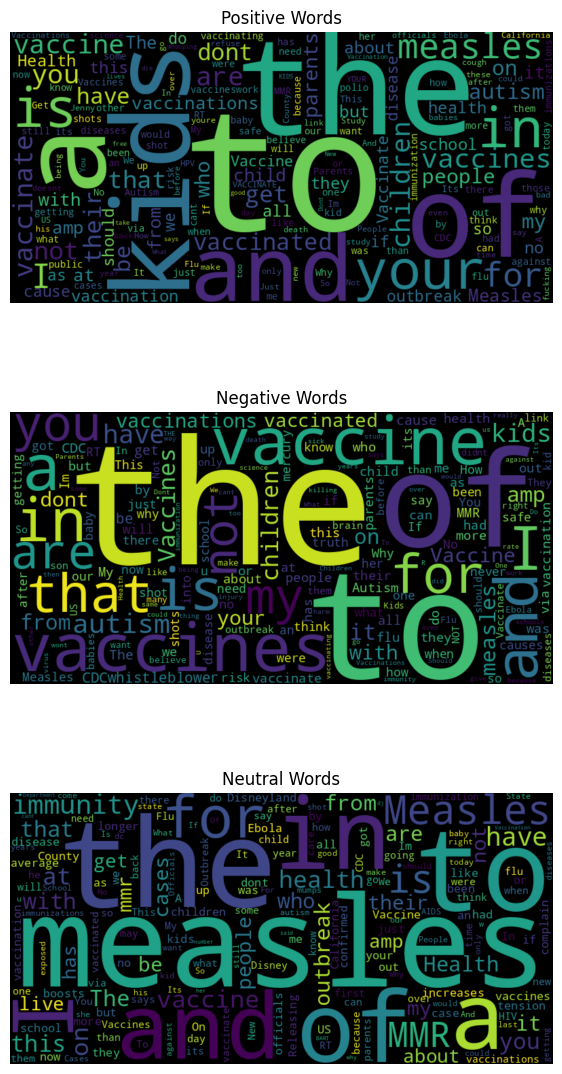

In [27]:


# Sample data for three sentiment classes
positive_text = train[train['label'] == 1]['safe_text']
negative_text = train[train['label'] == -1]['safe_text']
neutral_text = train[train['label'] == 0]['safe_text']

# Tokenize and preprocess the text if needed
# Count word frequencies for each sentiment class
positive_word_freq = Counter(" ".join(positive_text).split())
negative_word_freq = Counter(" ".join(negative_text).split())
neutral_word_freq = Counter(" ".join(neutral_text).split())

# Create word clouds
wordcloud_positive = WordCloud(width=800, height=400).generate_from_frequencies(positive_word_freq)
wordcloud_negative = WordCloud(width=800, height=400).generate_from_frequencies(negative_word_freq)
wordcloud_neutral = WordCloud(width=800, height=400).generate_from_frequencies(neutral_word_freq)

# Plot the word clouds
plt.figure(figsize=(7, 14))

plt.subplot(311)  # Positive
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Words')
plt.axis('off')

plt.subplot(312)  # Negative
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Words')
plt.axis('off')

plt.subplot(313)  # Neutral
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Words')
plt.axis('off')

plt.show()


## Distribution of sentiment labels

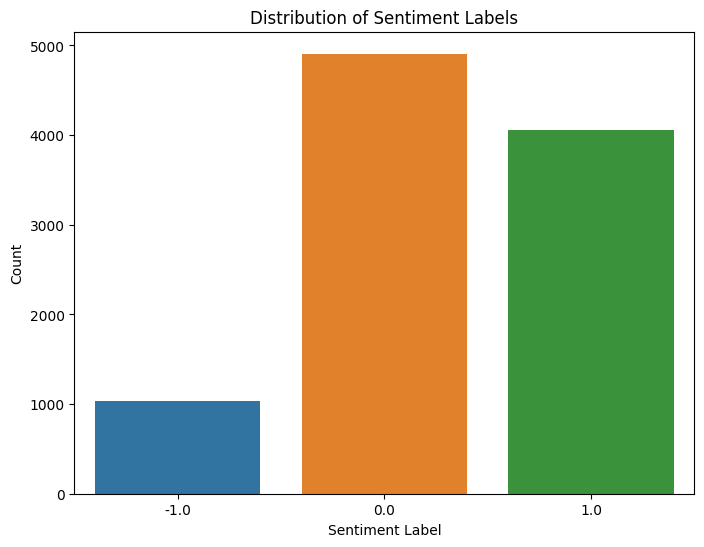

In [28]:
# Count the occurrences of each sentiment label
sentiment_counts = train['label'].value_counts()

# Create a bar plot to visualize the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")

# Customize the labels if needed
plt.xticks(rotation=360)  # Rotate x-axis labels for readability

# Show the plot
plt.show()

The plot visually represents the distribution of sentiment labels.


*  Netral(0.0) represented by the yellow bar has the highest occurences of 4908.
*  Positive(1.0) represented by the green bar has occurences of 4053 occurences.
*  Negative(-1.0) represented by the blue bar has 1038 occurences.
The neutral and positive sentiments are more prevalent compared to negative sentiments.







## Data Preprocessing

I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).

There are multiple ways to do split the dataset. You'll see two commented line showing you another one.

In [29]:
# Split the train data => {train, eval}
train, eval = train_test_split(train, test_size=0.2, random_state=42, stratify=train['label'])

In [30]:
train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickeys Measles has gone international,0.0,1.000000
3907,5GV8NEZS,S NEW Extends exemption from charitable immuni...,0.0,1.000000
795,EI10PS46,your ignorance on vaccines isnt just dangerous...,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,In other news Ive gone up like mmr,0.0,1.000000


In [31]:
eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Childrens Museum of Houston to Offer Free Vacc...,1.0,1.000000
1754,2DD250VN,no I was properly immunized prior to the perfo...,1.0,1.000000
3325,ESEVBTFN,thx for posting vaccinations are imperative A ...,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4175,IIN5D33V,Meeting tonight pm in room of the student cen...,1.0,1.000000


In [32]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


In [33]:
# Calculate class weights based on the distribution in the training set
class_weights = compute_class_weight("balanced", classes=np.unique(train['label']), y=train['label'])
# Convert to a dictionary for easier use
class_weights_dict = dict(zip(np.unique(train['label']), class_weights))


In [34]:
# Save splitted subsets
train.to_csv("train_subset.csv", index=False)
eval.to_csv("eval_subset.csv", index=False)

In [35]:
# load the dataset
dataset = load_dataset('csv',
                        data_files={'train': 'train_subset.csv',
                        'eval': 'eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [36]:
# load pretrained model from hugging face
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

preparing our data for training a machine learning model by converting text data into tokenized format and ensuring the labels are in a numerical format suitable for modeling.

In [37]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [38]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

 DatasetDict object containing training and evaluation datasets, each with features like 'input_ids', 'attention_mask', and 'labels'.

* input_ids: These are tokenized input sequences converted to IDs, ready for model input.

* attention_mask: This is a binary mask that indicates which tokens the model should pay attention to (usually 1 for tokens, 0 for padding).

* labels: These are the target labels for the text classification task.



In [39]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [40]:
# instantiate the train and validation sets
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)


In [41]:

notebook_login()

In [45]:
# adding custom training options or parameters to the TrainingArguments used to initialize the trainer

training_args = TrainingArguments(
    output_dir="covid_analysis_model",  # Directory where model checkpoints and logs will be saved
    num_train_epochs=5,  # Number of training epochs
    per_device_train_batch_size=8,  # Batch size per GPU or CPU
    per_device_eval_batch_size=8,  # Batch size for evaluation
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # save at the end of each training epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    push_to_hub=True,# Upload the model to the Hugging Face model hub
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [46]:
# perform text tokenization, padding, and formatting of train data so that it can be efficiently processed by deep learning models
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding ='max_length', max_length=128, return_tensors='pt')

In [47]:
# define Custom Trainer and modify loss function
class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs= False):
    labels= inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get('logits')
    # compute custom loss
    loss_function = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(model.device))
    loss = loss_function(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return(loss, outputs) if return_outputs else loss


In [48]:
# compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(y_true=labels, y_pred=predictions)
    return {"accuracy": acc}


In [49]:
# instantiate the trainer for trainer
custom_trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

In [50]:
# Train the model
custom_trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.790600,0.777959,0.772500
2,0.622700,0.753587,0.771000
3,0.444000,1.002122,0.774500
4,0.295400,1.352386,0.788500
5,0.169300,1.547639,0.779000


TrainOutput(global_step=5000, training_loss=0.47198175659179686, metrics={'train_runtime': 1173.1434, 'train_samples_per_second': 34.092, 'train_steps_per_second': 4.262, 'total_flos': 2630805285507840.0, 'train_loss': 0.47198175659179686, 'epoch': 5.0})

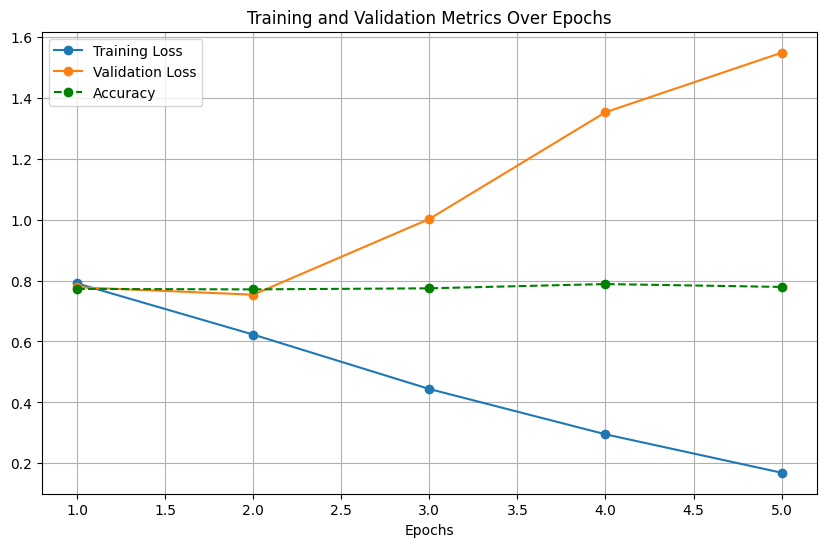

In [51]:
# Sample data
Epochs = [1, 2, 3, 4, 5]
Training_loss = [0.790600	, 0.622700, 0.444000, 0.295400 , 0.169300]
Validation_loss = [0.777959, 0.753587, 1.002122, 1.352386, 1.547639]
Accuracy = [0.772500, 0.771000, 0.774500, 0.788500, 0.779000]


# Create a single plot for all metrics
plt.figure(figsize=(10, 6))
plt.title("Training and Validation Metrics Over Epochs")
plt.xlabel("Epochs")
plt.grid()

# Plot Training Loss
plt.plot(Epochs, Training_loss, label='Training Loss', marker='o')

# Plot Validation Loss
plt.plot(Epochs, Validation_loss, label='Validation Loss', marker='o')

# Plot Accuracy
plt.plot(Epochs, Accuracy, label='Accuracy', marker='o', linestyle='--', color='green')

plt.legend()
plt.show()

In [52]:
# Launch the final evaluation
custom_trainer.evaluate()

{'eval_loss': 0.7535868883132935,
 'eval_accuracy': 0.771,
 'eval_runtime': 16.0824,
 'eval_samples_per_second': 124.359,
 'eval_steps_per_second': 15.545,
 'epoch': 5.0}

In [53]:
notebook_login()

In [55]:
custom_trainer.push_to_hub
tokenizer.push_to_hub( "covid_analysis_model")

CommitInfo(commit_url='https://huggingface.co/phinm/covid_analysis_model/commit/7e88318dca7412d89f92e03e0bde51e32771d727', commit_message='Upload tokenizer', commit_description='', oid='7e88318dca7412d89f92e03e0bde51e32771d727', pr_url=None, pr_revision=None, pr_num=None)

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitaite to read more and to ask questions, the Learning is a lifelong activity.